# AnyoneAI - Project II

# Making Estimations with our NBA dataset

In our first project, we learn how to create our own datasets by using a public API, Python and Pandas. We're now going to explore how to make predictive models for regression and classification tasks using ScikitLearn

The goals of this project are:
- Learn how to define a prediction task
- Selecting evaluation metrics and baseline models
- Perform feature engineering and standarization
- Training and using predictive models: Univariable and Multivariate Linear Regression, Classification
- Understand how Gradient Descent works by implementing a Linear Regressor in python

## Using Regression Models to Estimate players Salaries

A player's salary can be explained by a lot of factors: 

- Years in the league: NBA contracts are limited in price, players have caps on how much money they make depending on their years playing in the league
- Age: Highly correlated to the previous one, NBA players have a minimun age of 19 years
- Draft position: players out of USA universities are selected each year through a process called draft, in which each team selects a player in a predefined order for 2 rounds (meaning only 60 players are drafted each year). A rookie contract value depends on the draft position. (Undrafted players have to negotiate a salary independently)
- Performance in statistical categories: after the rookie contract, players can negotiate freely with teams, and usually statistical categories like points, rebounds and assists are extremely important.  
- Team: Even though there are limits to what all teams can expend in players salary, they all allocate their resources differently, and can be more willing to pay the penalties incurred by exceeding those limitations.
- Year in which the contract was signed: the mininum and maximum values of contracts possibles in the NBA changes depending on league revenue (television contracts, sponsorships, etc), so if the amount of money the teams make increases, players can negotiate bigger contracts.
- Intangibles: players can be valued also in things that are not easily translated to a statistic, good defensive players might not always have great stats but can be extremely important for a team, the same can be said about veteran players that help young ones to learn and are good locker-room guys.

But we're going to take a simplified approach, we'll try to use the data we already have to make the best estimator possible, and then we will analyze what went right and what could've gone wrong with our results.

### Analyzing our data

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/project2_players_df.csv")


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PERSON_ID     460 non-null    int64  
 1   PLAYER_NAME   460 non-null    object 
 2   TEAM_NAME     438 non-null    object 
 3   POSITION      460 non-null    object 
 4   HEIGHT        460 non-null    int64  
 5   WEIGHT        460 non-null    int64  
 6   COUNTRY       460 non-null    object 
 7   BIRTHDATE     460 non-null    object 
 8   SEASON_EXP    460 non-null    int64  
 9   DRAFT_NUMBER  456 non-null    object 
 10  GP            459 non-null    float64
 11  MIN           459 non-null    float64
 12  PTS           459 non-null    float64
 13  REB           459 non-null    float64
 14  AST           459 non-null    float64
 15  STL           459 non-null    float64
 16  BLK           459 non-null    float64
 17  GAME_DATE     439 non-null    object 
 18  Salary        460 non-null    

In [ ]:
data.dropna(subset=["PTS"], inplace=True)
data.dropna(subset=["TEAM_NAME"], inplace=True)


In [ ]:
data.shape

(437, 20)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/dis

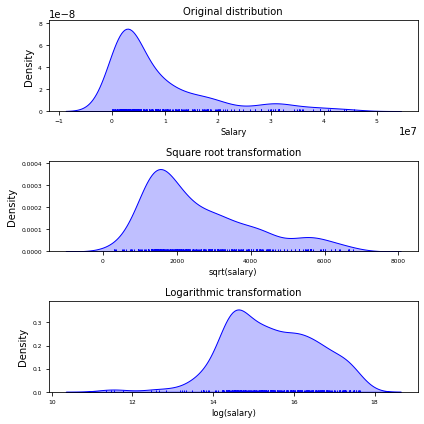

In [ ]:
# Variable behavior to predict

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 6))
sns.distplot(
    data.Salary,
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[0]
)
axes[0].set_title("Original distribution", fontsize = 'medium')
axes[0].set_xlabel('Salary', fontsize='small') 
axes[0].tick_params(labelsize = 6)

sns.distplot(
    np.sqrt(data.Salary),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[1]
)
axes[1].set_title("Square root transformation", fontsize = 'medium')
axes[1].set_xlabel('sqrt(salary)', fontsize='small') 
axes[1].tick_params(labelsize = 6)

sns.distplot(
    np.log(data.Salary),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[2]
)
axes[2].set_title("Logarithmic transformation", fontsize = 'medium')
axes[2].set_xlabel('log(salary)', fontsize='small') 
axes[2].tick_params(labelsize = 6)

fig.tight_layout()

Let's have another look at our previously generated dataset. 

1.1. Plot all players statistics ("PTS", "REB", "AST","STL","BLK") against salary

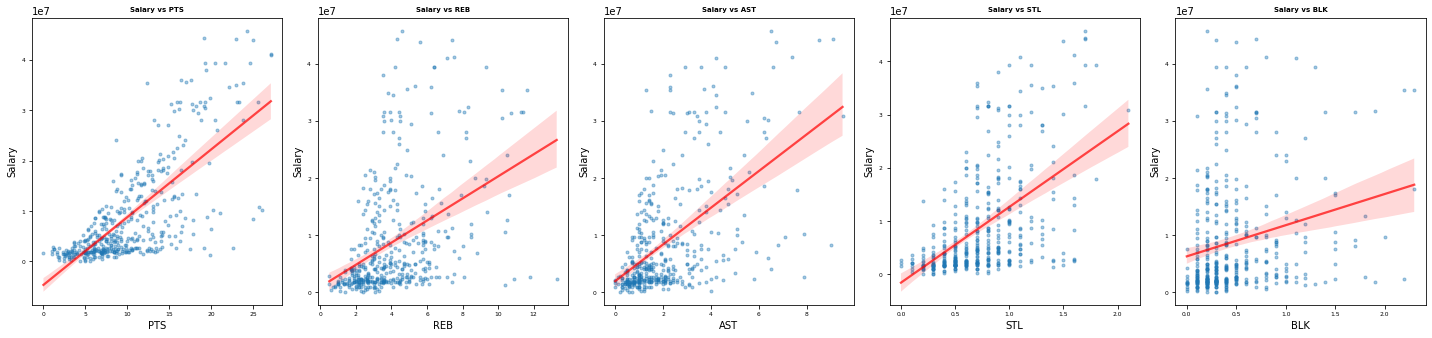

In [ ]:
fig, axes = plt.subplots(ncols=5, figsize=(20, 5))
axes = axes.flat
columnas_numeric = data[["PTS", "REB", "AST","STL","BLK"]].select_dtypes(
    include=['float64', 'int']).columns

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x           = data[colum],
        y           = data['Salary'],
        marker      = '.',
        scatter_kws = {"alpha":0.4},
        line_kws    = {"color":"r","alpha":0.7},
        ax          = axes[i]
    )
    axes[i].set_title(f"Salary vs {colum}", fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)


fig.tight_layout()
plt.subplots_adjust(top=0.9)

1.2. What can we say about these distributions?

**The salary based on the points has a more linear behavior than the rest of the graphs. The latter have very isolated points and no trend is observed.**

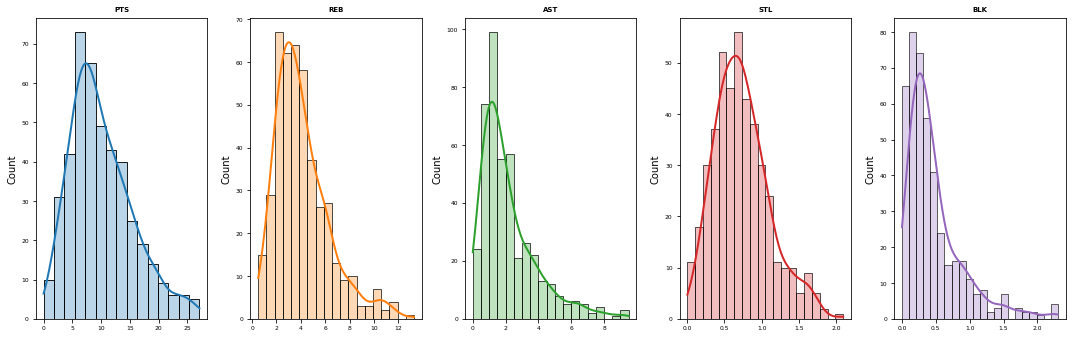

In [ ]:
fig, axes = plt.subplots(ncols=5, figsize=(15, 5))
axes = axes.flat
columnas_numeric = data[["PTS", "REB", "AST","STL","BLK"]].select_dtypes(
    include=['float64', 'int']).columns


for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = data,
        x       = colum,
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)


In [ ]:
# Correlation between numeric columns
# ==============================================================================

def tidy_corr_matrix(corr_mat):
    
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)



corr_matrix = data.select_dtypes(include=['float64', 'int']
                                 ).corr(method='pearson')

tidy_corr_matrix(corr_matrix).head()

,variable_1,variable_2,r,abs_r
51,GP,SEASON_EXP,0.978438,0.978438
40,SEASON_EXP,GP,0.978438,0.978438
77,PTS,MIN,0.885180,0.885180
66,MIN,PTS,0.885180,0.885180
3,PERSON_ID,SEASON_EXP,-0.835736,0.835736


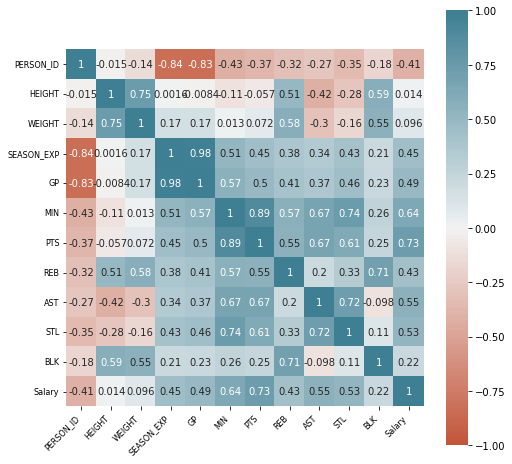

In [ ]:
# Heatmap correlation matrix

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = True,
    annot_kws = {"size": 10},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)

**As we can see, the PTS with the salary present the best correlation**

### Splitting the Dataset

1.3. Split the dataset into train and testing sets. Use the Sklearn function for train/test splitting. Make sure to set the random state for reproducibility.

In [ ]:
#We define our variables x and y

y = data["Salary"]
X = data.drop("Salary", axis=1)

#We split data to train and data to test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, 
                                                    random_state= 8)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(393, 19)
(393,)
(44, 19)
(44,)


### Baseline Model and Evaluation Metric

In every project, we need a baseline model that implements a very simple algorithm or heuristic so we can compare our results with it. 
In this case, we could create a function that always returns the average player salary, evaluate that, and then compare the result with our modeling to see if we are improving. 

We need an evaluation metric to see how well our models fit the data. For this project we will use [Mean Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error) as our regression evaluation metric, because it is a really simple metric to interpret. A lower value means the model performs better. 

For this particular problem, we will always round the value, as we don't need decimals for this task.

1.4. Create a Baseline model class that implements  fit() and predict() methods. As this model will not consider any other variable, the fit method should only receive a list of all players salaries. The predict method should receive and iterable and return a numpy array with the same length but every element should have the same value (the average salary)

In [ ]:
class BaselineModel():
     
    def fit(self, y_train):
        y_train = [int(round(i)) for i in y_train]
        self.mean = np.mean(y_train)

            
    def predict(self, X):
        y_result = np.zeros(len(X))
        y_result.fill(self.mean)
        y_result = y_result.astype(int)

        return y_result

        

1.5. Evaluate the performance of our BaselineModel on the test set using mean_absolute_error from Sklearn (round the result)

In [ ]:
model = BaselineModel()

In [ ]:
model.fit(y_train)

In [ ]:
y_train

251     2316240
169    17357143
290     2641691
4       2641691
445     7422000
         ...   
357     4670160
143     4910000
140      925258
380     3768342
358     1517981
Name: Salary, Length: 393, dtype: int64

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred

array([9183697, 9183697, 9183697, 9183697, 9183697, 9183697, 9183697,
       9183697, 9183697, 9183697, 9183697, 9183697, 9183697, 9183697,
       9183697, 9183697, 9183697, 9183697, 9183697, 9183697, 9183697,
       9183697, 9183697, 9183697, 9183697, 9183697, 9183697, 9183697,
       9183697, 9183697, 9183697, 9183697, 9183697, 9183697, 9183697,
       9183697, 9183697, 9183697, 9183697, 9183697, 9183697, 9183697,
       9183697, 9183697])

In [ ]:
baseline_mae = mean_absolute_error(y_test, y_pred)
baseline_mae = int(round(baseline_mae))

**The error iS 6716417**

### Regression with a single variable

You're now going to start modeling data. We will start with a really simple approach, selecting just one variable, and doing a regression to see if we improve upon our baseline.


1.6. Select the variable you think would provide the best fit. Perform feature scaling on this variable using a Sklearn scaler.

In [ ]:
Xp_train = X_train["PTS"]
Xp_test = X_test["PTS"]
yp_train = y_train
yp_test = y_test

In [ ]:
# Define the Sklearn scaler
scaler = StandardScaler()


Xp_train = Xp_train.values.reshape(-1,1)
Xp_test = Xp_test.values.reshape(-1,1)

scaler.fit(Xp_train)

Xp_train = scaler.transform(Xp_train)
Xp_test = scaler.transform(Xp_test) 



1.7. Train a model with [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) from Sklearn using the default parameters. Evaluate the model's performance on the test set using the selected metric.

In [ ]:
regressor = SGDRegressor()

regressor.fit(Xp_train, yp_train)

yp_pred = regressor.predict(Xp_test)


In [ ]:
yp_pred

array([ 6934470.22135289,  6376804.50244723,  -454600.55414706,
       10419880.96451325,  5540305.92408875,  4146141.62682461,
       16972453.16165471, 13068793.12931512,  5261473.06463592,
         -36351.26496782,  4006725.19709819, 14462957.42657926,
       17948368.16973961,  8049801.65916421, -1709348.42168479,
        5540305.92408875,  2333728.04038122,  5819138.78354158,
       12650543.84013587, -1848764.8514112 ,  8049801.65916421,
        2751977.32956047,  9722798.81588117,  1776062.32147557,
       13068793.12931512,  1636645.89174915,   381898.02421143,
        7073886.65107931, -2824679.8594961 ,  4843223.77545668,
       19621365.32645658, 15717705.29411699, 31332345.42347538,
       -3661178.43785459,  2333728.04038122,  5540305.92408875,
        5261473.06463592,  8328634.51861703,  4006725.19709819,
        1636645.89174915,  3449059.47819254,  4146141.62682461,
       18645450.31837168, 21154946.05344714])

In [ ]:
default_mae = mean_absolute_error(yp_test, yp_pred)
default_mae = int(round(default_mae))

1.8. Read the Sklearn documentation, and write a function that tries different configurations for the hyperparameters for training: epochs, learning rate and alpha. For each combination of parameters, evaluate the trained algorithm on the test set, then save the results of each hyperparameter combination, finally select the one that has the best MAE (meaning the lowest number) and print the combination and the MAE.

In [ ]:
def search_best_hyperparameters(max_iter, eta0):
    result = {
        "hyperparameters": {"max_iter": None, "eta0": None}, 
        "mae": None
    }

    for i in max_iter:
      for j in eta0:
        
        regressor = SGDRegressor(max_iter = i, eta0 = j, random_state = 8)
        regressor.fit(Xp_train, yp_train)
        yp_pred = regressor.predict(Xp_test)
        mae = round(mean_absolute_error(yp_test, yp_pred))

        if (result["mae"] == None) or (result["mae"] > mae):
          result["hyperparameters"]["max_iter"] = i
          result["hyperparameters"]["eta0"] = j
          result["mae"] = mae

    return result

In [ ]:
# Example list of hyperparameters values
max_iter = [1000, 1000000]
eta0 = [0.0001, 0.001, 0.01, 0.1]

result = search_best_hyperparameters(max_iter, eta0)
print(result)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


{'hyperparameters': {'max_iter': 1000, 'eta0': 0.0001}, 'mae': 4479514}


1.9. Compare the results of the baseline, the SGDRegressor with default parameters and the one with the best combination of hyperparameters you could find. (replace variables with the ones you used)

In [ ]:
print("Mean Absolute Error for each model:")
print(f"Baseline: {baseline_mae}")
print(f"Default SGDRegressor: {default_mae}")
print(f"Best SGDRegressor: {result['mae']}")

Mean Absolute Error for each model:
Baseline: 6716417
Default SGDRegressor: 4797039
Best SGDRegressor: 4479514


### Multivariate Linear Regression

To improve our model, we will add more features to it. We will have to do some processing to our dataset to be able to use the data.
We'll start with the following variables:

- Points
- Rebounds
- Assists
- Blocks
- Experience
- Position
- Draft Number


1.10. Create a copy of the dataset generated in the first project that only has the following columns (and player id as an index):

["PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER", "TEAM_NAME", "SALARY"]

In [ ]:
data_linearR = data[["PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION",
                     "DRAFT_NUMBER","TEAM_NAME","PERSON_ID", "Salary"]].copy()
data_linearR.set_index("PERSON_ID", inplace=True, drop=True)
data_linearR.index.name = None
data_linearR


,PTS,REB,AST,BLK,SEASON_EXP,POSITION,DRAFT_NUMBER,TEAM_NAME,Salary
1630173,6.5,5.1,0.8,0.5,1,Forward,20,Raptors,2711280
203500,9.3,7.9,1.4,0.9,8,Center,12,Grizzlies,17073171
1628389,13.2,8.2,3.5,0.9,4,Center,14,Heat,28103550
1630583,3.3,2.4,0.5,0.3,0,Forward,30,Grizzlies,1994520
200746,19.1,8.1,1.9,1.1,15,Center,2,Nets,2641691
...,...,...,...,...,...,...,...,...,...
201152,12.9,5.9,1.8,0.4,14,Forward,12,Raptors,14190000
1629027,25.0,3.9,9.0,0.2,3,Guard,5,Hawks,8326471
1630209,6.0,5.7,1.0,0.4,0,Center,Undrafted,Heat,1489065
203469,8.5,6.0,1.4,0.6,9,Forward,4,Hornets,2389641


#### Feature Engineering

1.11. Binning the DRAFT_NUMBER feature. Draft position directly impacts salaries during the first few years, but second round players and undrafted players don't have guaranteed contracts. So we're gonna divide the bins like this: 

       - 1 to 15: firstround_lottery
       - 15 to 30: firstround_non_lottery
       - 30 to 60: second_round
       - Undrafted: undrafted
       
Create a new column named DRAFT using these 4 categories. Drop the draft number column.

In [ ]:
data_linearR["DRAFT_NUMBER"].unique()

array(['20', '12', '14', '30', '2', '17', '21', '22', '15', '51', '3',
       '23', 'Undrafted', '43', '9', '1', '27', '6', '46', '7', '4', '40',
       '53', '48', '25', '19', '42', '18', '35', '31', '44', '39', '13',
       '11', '28', '10', '36', '45', '33', '8', '49', '32', '24', '41',
       '5', '34', '38', '29', '52', '26', nan, '37', '50', '16', '47',
       '55', '54', '58'], dtype=object)

In [ ]:
data_linearR["DRAFT_NUMBER"] = data_linearR["DRAFT_NUMBER"].replace("Undrafted",70)
data_linearR["DRAFT_NUMBER"] = data_linearR["DRAFT_NUMBER"].replace(np.nan,70)

In [ ]:
data_linearR["DRAFT"] = np.where((data_linearR["DRAFT_NUMBER"].astype(int)) < 15,
                                 "firstround_lottery", data_linearR["DRAFT_NUMBER"])
data_linearR["DRAFT"] = np.where((data_linearR["DRAFT_NUMBER"].astype(int)) >= 15,
                                 "firstround_non_lottery", data_linearR["DRAFT"])
data_linearR["DRAFT"] = np.where((data_linearR["DRAFT_NUMBER"].astype(int)) >= 30,
                                 "second_round", data_linearR["DRAFT"])
data_linearR["DRAFT"] = np.where((data_linearR["DRAFT_NUMBER"].astype(int)) > 60,
                                 "undrafted", data_linearR["DRAFT"])

In [ ]:
data_linearR.groupby("DRAFT").size()

DRAFT
firstround_lottery        153
firstround_non_lottery    106
second_round              110
undrafted                  68
dtype: int64

In [ ]:
data_linearR = data_linearR.drop("DRAFT_NUMBER", axis=1)

In [ ]:
data_linearR.head()

,PTS,REB,AST,BLK,SEASON_EXP,POSITION,TEAM_NAME,Salary,DRAFT
1630173,6.5,5.1,0.8,0.5,1,Forward,Raptors,2711280,firstround_non_lottery
203500,9.3,7.9,1.4,0.9,8,Center,Grizzlies,17073171,firstround_lottery
1628389,13.2,8.2,3.5,0.9,4,Center,Heat,28103550,firstround_lottery
1630583,3.3,2.4,0.5,0.3,0,Forward,Grizzlies,1994520,second_round
200746,19.1,8.1,1.9,1.1,15,Center,Nets,2641691,firstround_lottery


1.12. Encode the categorical features: DRAFT, POSITION and TEAM_NAME

In [ ]:
data_linearR = pd.get_dummies(data_linearR, columns=['DRAFT','POSITION','TEAM_NAME'])
data_linearR.head()

,PTS,REB,AST,BLK,SEASON_EXP,Salary,DRAFT_firstround_lottery,DRAFT_firstround_non_lottery,DRAFT_second_round,DRAFT_undrafted,...,TEAM_NAME_Pistons,TEAM_NAME_Raptors,TEAM_NAME_Rockets,TEAM_NAME_Spurs,TEAM_NAME_Suns,TEAM_NAME_Thunder,TEAM_NAME_Timberwolves,TEAM_NAME_Trail Blazers,TEAM_NAME_Warriors,TEAM_NAME_Wizards
1630173,6.5,5.1,0.8,0.5,1,2711280,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
203500,9.3,7.9,1.4,0.9,8,17073171,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1628389,13.2,8.2,3.5,0.9,4,28103550,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1630583,3.3,2.4,0.5,0.3,0,1994520,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
200746,19.1,8.1,1.9,1.1,15,2641691,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Modeling

1.13. Split the dataset into train and test

In [ ]:
y = data_linearR["Salary"]
X = data_linearR.drop("Salary", axis= 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, 
                                                    random_state= 8)

1.14. Perform feature scaling in all the numerical features ("PTS", "REB", "AST", "BLK", "SEASON_EXP") except for draft number

In [ ]:
scaler = MinMaxScaler()

scaler.fit(X_train[["PTS", "REB", "AST", "BLK", "SEASON_EXP"]])

X_train[["PTS", "REB", "AST", "BLK", "SEASON_EXP"]] = scaler.transform(
    X_train[["PTS", "REB", "AST", "BLK", "SEASON_EXP"]])

X_test[["PTS", "REB", "AST", "BLK", "SEASON_EXP"]] = scaler.transform(
    X_test[["PTS", "REB", "AST", "BLK", "SEASON_EXP"]]) 

In [ ]:
X_train.head()

,PTS,REB,AST,BLK,SEASON_EXP,DRAFT_firstround_lottery,DRAFT_firstround_non_lottery,DRAFT_second_round,DRAFT_undrafted,POSITION_Center,...,TEAM_NAME_Pistons,TEAM_NAME_Raptors,TEAM_NAME_Rockets,TEAM_NAME_Spurs,TEAM_NAME_Suns,TEAM_NAME_Thunder,TEAM_NAME_Timberwolves,TEAM_NAME_Trail Blazers,TEAM_NAME_Warriors,TEAM_NAME_Wizards
1629642,0.214022,0.226562,0.073684,0.217391,0.111111,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
203925,0.409594,0.210938,0.168421,0.086957,0.388889,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
200794,0.494465,0.515625,0.231579,0.434783,0.833333,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
200746,0.704797,0.593750,0.200000,0.478261,0.833333,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1630172,0.335793,0.304688,0.136842,0.260870,0.055556,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


1.15. Write a function to train a SGDRegressor model with the new dataset, trying different hyperparameters, and selecting the one that performs the best.

In [ ]:
def search_best_hyperparameters(max_iter, eta0):
  result_linearR = {
        "hyperparameters": {"max_iter": None, "eta0": None}, 
        "mae": None
  }

  for i in max_iter:
    for j in eta0:
        
      regressor = SGDRegressor(max_iter = i, eta0 = j, random_state = 8)
      regressor.fit(X_train, y_train)
      y_pred = regressor.predict(X_test)
      mae = round(mean_absolute_error(y_test, y_pred))

      if (result_linearR["mae"] == None) or (result_linearR["mae"] > mae):
        result_linearR["hyperparameters"]["max_iter"] = i
        result_linearR["hyperparameters"]["eta0"] = j
        result_linearR["mae"] = mae

  return  result_linearR

In [ ]:
max_iter = [1000, 10000, 100000, 1000000]
eta0 = [0.0001, 0.001, 0.01, 0.1]

result_linearR = search_best_hyperparameters(max_iter, eta0)
print(result_linearR)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linea

{'hyperparameters': {'max_iter': 1000, 'eta0': 0.001}, 'mae': 4840237}


1.16. How did the model performed compared to our univariate models? 

In [ ]:
print("Mean Absolute Error for each model:")
print(f"Baseline: {baseline_mae}")
print(f"Default SGDRegressor: {default_mae}")
print(f"Best SGDRegressor: {result['mae']}")
print(f"Best SGDRegressor (Multivariate Linear Regression): {result_linearR['mae']}")

Mean Absolute Error for each model:
Baseline: 6716417
Default SGDRegressor: 4797039
Best SGDRegressor: 4479514
Best SGDRegressor (Multivariate Linear Regression): 4840237


### DecisionTreeRegressor

It is possible that this problem might not be easily resolvable by a linear model, or that there could be better types of algorithms to tackle it. As an example, let's try with a very used algorithm, a Decision Tree.



1.17. Create new model using [DecisionTreeRegressor](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html) from scikit learn. We will use again all variables, and try different configuration for the following hyperparameters:

- max_depth
- min_samples_leaf
- max_features

These are all regularization hyperparameters for this algorithm. Read the documentation to get a better grasp of what each one does.

In [ ]:
def search_best_hyperparameters(max_depth, min_samples_leaf, max_features):
  result_DTR = {
        "hyperparameters": {"max_depth": None, "min_samples_leaf": None,
                            "max_features": None }, "mae": None
  }

  for i in max_depth:
    for j in min_samples_leaf:
      for h in max_features:
        
        regressor = DecisionTreeRegressor(max_depth = i, min_samples_leaf = j, max_features = h, random_state = 8)
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
        mae = round(mean_absolute_error(y_test, y_pred))

        if (result_DTR["mae"] == None) or (result_DTR["mae"] > mae):
          result_DTR["hyperparameters"]["max_depth"] = i
          result_DTR["hyperparameters"]["min_samples_leaf"] = j
          result_DTR["hyperparameters"]["max_features"] = h
          result_DTR["mae"] = mae

  return  result_DTR

In [ ]:
# List of hyperparameter example values
max_depth = [5, 10, 15, 20, 50]
min_samples_leaf = [2, 10, 20, 50]
max_features = [5, 10]

result_DTR = search_best_hyperparameters(max_depth, min_samples_leaf, max_features)
print(result_DTR)

{'hyperparameters': {'max_depth': 10, 'min_samples_leaf': 2, 'max_features': 10}, 'mae': 3637065}


1.18. Compare the results obtained with the best decision tree model against the baseline, default and the best params sgd regressors-

In [ ]:
print("Mean Absolute Error for each model:")
print(f"Baseline: {baseline_mae}")
print(f"Default SGDRegressor: {default_mae}")
print(f"Best SGDRegressor: {result['mae']}")
print(f"Best SGDRegressor (Multivariate Linear Regression): {result_linearR['mae']}")
print(f"Best DecisionTreeRegressor: {result_DTR['mae']}")

Mean Absolute Error for each model:
Baseline: 6716417
Default SGDRegressor: 4797039
Best SGDRegressor: 4479514
Best SGDRegressor (Multivariate Linear Regression): 4840237
Best DecisionTreeRegressor: 3637065


### Analyzing our results

Based on what you found, and what you read about players salaries above, answer the following: 

1.19. Which kind of model worked better in this dataset, linear or non linear models? Do you have any hypothesis about why? 

**The non-linear model provided better results, this is because the linear behavior is affected by the isolated points generated by the salaries of the novice players.**

1.20. Is there something else we could do to improve our results if wanted to make a more accurate model?

**The solution would be to give special treatment to novice players, since they do not carry important information but rather affect the linear behavior of the model.**

## Star or no Star? Predicting players All-NBA selections

In this section we're going to try to solve a different question:

Can we train a model to predict which players are going to be selected to ALL-NBA teams at the end of the season? This is a [binary classification](https://en.wikipedia.org/wiki/Binary_classification) task, so we're training our first classifier model to solve this problem.

Consider that:

- Being selected as part of the [All-NBA teams](https://en.wikipedia.org/wiki/All-NBA_Team) is different than being selected for [All-Star Game](https://en.wikipedia.org/wiki/NBA_All-Star_Game). 
- You're trying to predict All-NBA selections, which takes place after the regular season but before playoffs start, so we're only going to use players and teams statistics about the regular season (you're not going to consider if the players got to the NBA finals for example). 
- All Star game takes place at the middle point of the regular season, players are selected based on partial season performance, and the general public has 50% of the votes, so it is also a more popularity-based award.
- All-NBA teams are divided in first, second and third teams of 5 players each, divided by position: 2 front court players (guards), 2 backcourt players (forwards) and 1 center.
- As only 15 players are selected to All-NBA teams each year (out of more than 400 qualifying players), our dataset is going to be imbalanced. You're going to have to find a good strategy to deal with this inbalance.

### Analyzing the data

To do this task, you're going to need historical information about All-NBA selections. We'll use a dataset that contains information about players from season starting in 1990 and ending in the 2018-2019 season.
The dataset contains statistics for all players, and a column named "all-nba" that is going to be our target variable, 1 means the player was selected to an All-NBA team that season.


2.1. Load the dataset "all_nba_1990_2017_dataset.csv" from disk, look at the data inside it and print:
- number of rows
- number of seasons
- number of unique players
- number of all-nba selections vs non selected 

In [ ]:
import pandas as pd
all_nba_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_1990_2017_dataset.csv", index_col=0)

In [ ]:
all_nba_df.columns

Index(['season_id', 'player_id', 'player_season', 'player', 'season',
       'season_start', 'team', 'games', 'gamesstarted', 'mp', 'fg_perc',
       '3p_perc', '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov',
       'pf', 'pts', 'all_nba'],
      dtype='object')

In [ ]:
print(f"Number of rows : {len(all_nba_df.index)}")
print(f"Number of season: {len(all_nba_df.groupby('season').size())}")
print(f"Number of unique players: {len(all_nba_df['player_id'].unique())}")
print(f"Number of all-nba: {len(all_nba_df[all_nba_df['all_nba']==1])} vs Number of non selected: {len(all_nba_df[all_nba_df['all_nba']==0])}")

Number of rows : 14825
Number of season: 39
Number of unique players: 2718
Number of all-nba: 496 vs Number of non selected: 14329


### Splitting the dataset

2.2. Split the dataset in training and test sets. Make sure to keep the distribution of values in the target variable.

Use columns: 'team', 'games', 'games_started', 'mp', 'fg_perc', '3p_perc',
       '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts','all_nba'
       
    

In [ ]:
X = all_nba_df[['team', 'games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc',
                '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf',
                'pts']].copy()

y = all_nba_df[['all_nba']].copy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    random_state= 8, stratify=y)

### Baseline model and Evaluation Metrics

In this oportunity we'll define our baseline model as the model we can train with the minimun amount of work on the dataset. For this you're gonna train a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) with default parameters, and without doing any preprocessing to our data.

2.3. Let's start with a simple test. What accuracy would we get if we had a baseline model that always predicted 0 (player not selected to all nba)?

In [ ]:
trueValues = len(y_test[y_test['all_nba']==0])
totalValues = len(y_test.index)

In [ ]:
Accuracy = (trueValues / totalValues) * 100
print(f"Accuracy: {round(Accuracy, 2)}%")

Accuracy: 96.66%


2.4. What does this tells us about the data and the use of accuracy as an evaluation metric?

2.5. Scale all numerical features in the dataset (we will keep this scaling for future modeling, so make sure to do it in place)

In [ ]:
#We separate into numeric and non-numeric variables.

numerical_features = X_train.select_dtypes(include=['float64', 'int'])
categorical_features = X_train.select_dtypes(include=['object'])

numerical_features.columns, categorical_features.columns

(Index(['games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc',
        'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts'],
       dtype='object'), Index(['team'], dtype='object'))

In [ ]:
scaler = StandardScaler()

scaler.fit(X_train[['games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc',
        'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']
       ])

X_train[['games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc',
        'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']
       ] = scaler.transform(X_train[['games', 'gamesstarted', 'mp', 'fg_perc', 
                                     '3p_perc', '2p_perc','ft_perc', 'trb',
                                     'ast', 'stl', 'blk', 'tov', 'pf', 'pts']])

        
X_test[['games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc',
        'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']
       ] = scaler.transform(X_test[['games', 'gamesstarted', 'mp', 'fg_perc', 
                                 '3p_perc', '2p_perc', 'ft_perc', 'trb', 'ast',
                                 'stl', 'blk', 'tov', 'pf', 'pts']]) 


2.6. Train a LogisticRegression with default parameters, use only the numerical features (omit the team information for now). This will be our baseline model. 

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000).fit(
    X_train[['games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc',
             'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']], y_train)

y_pred = model.predict(X_test[['games', 'gamesstarted', 'mp', 'fg_perc', 
                               '3p_perc', '2p_perc','ft_perc', 'trb', 'ast', 
                               'stl', 'blk', 'tov', 'pf', 'pts']])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2.7. Evaluate our baseline model using this metrics: 

    - accuracy
    - precision
    - recall
    - f1

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [ ]:
print(f"Accuracy: {round(accuracy * 100,3)}%")
print(f"Precision: {round(precision * 100, 3)}%")
print(f"Recall: {round(recall * 100, 3)}%")
print(f"F1: {round(f1 * 100, 3)}%")

Accuracy: 98.246%
Precision: 81.333%
Recall: 61.616%
F1: 70.115%


From now on, you'll be evaluating you model primarily using the F1 Score metric, but we also want to avoid models that have very low recall. 

### Classification

#### Feature engineering

2.8. One hot encode the Team feature. Make sure to drop the original column.

In [ ]:
# X_train = pd.get_dummies(X_train, columns=["team"])
# X_test = pd.get_dummies(X_test, columns=["team"])

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')
enc_train = enc.fit_transform(X_train[['team']]).toarray()
enc_test = enc.fit_transform(X_test[['team']]).toarray()

# define the name of the columns
feature_names = enc.get_feature_names_out()

# transform to dataframe
enc_df_train = pd.DataFrame(enc_train, columns = feature_names)
enc_df_test = pd.DataFrame(enc_test, columns = feature_names)

# merge
X_train = X_train.reset_index(drop=True)
X_train = X_train.merge(enc_df_train, left_index=True, right_index=True)

X_test = X_test.reset_index(drop=True)
X_test = X_test.merge(enc_df_test, left_index=True, right_index=True)

X_train = X_train.drop("team", axis=1)
X_test = X_test.drop("team", axis=1)

#### Modeling

2.9. Train a logistic regresion model, find the best hyperparameters for: tols, C and max_iter. Try at least 4 values of each parameter. Remember to select based on f1 score, but report also precision and recall. Save the best performing model to use in the next steps.

In [ ]:
def search_best_hyperparameters(tol, C, max_iter):
  result_LR = {
        "hyperparameters": {"tol": None, "C": None,
                            "max_iter": None }, "f1": None
  }

  for i in tol:
    for j in C:
      for h in max_iter:
        
        model_nba = LogisticRegression(tol = i,C = j,max_iter = h,random_state = 8)
        model_nba.fit(X_train, y_train)
        y_pred = model_nba.predict(X_test)
        f1 = round(f1_score(y_test, y_pred)*100,3)

        if (result_LR["f1"] == None) or (result_LR["f1"] > f1):
          result_LR["hyperparameters"]["tol"] = i
          result_LR["hyperparameters"]["C"] = j
          result_LR["hyperparameters"]["max_iter"] = h
          result_LR["f1"] = f1

  return  result_LR

In [ ]:
# List of hyperparameter example values
tol = [0.1, 0.01,0.001]
C = [1.0,0.5,0.1]
max_iter = [100,150,500]

result_LR = search_best_hyperparameters(tol, C, max_iter)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [ ]:
print(result_LR)

{'hyperparameters': {'tol': 0.1, 'C': 0.1, 'max_iter': 100}, 'f1': 72.515}


In [ ]:
model_nba = LogisticRegression(tol = 0.1, C = 0.1, max_iter = 100)
model_nba.fit(X_train, y_train)
y_pred = model_nba.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Evaluating on New Data

You're now going to evaluate the results on a test dataset that has not being used to train or do hyperparameter tuning, this is sometimes known as a Test set (in this cases the test set used for training is known as validation set, yeah, it's confusing, but you can read about it [here](https://machinelearningmastery.com/difference-test-validation-datasets/))

2.10. Load the dataset [all_nba_2018_dataset.csv](https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv) in one dataframe and [all_nba_2018_selections.csv](https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv)) in another, then:

    - Scale the numerical features. Columns season_id, player_id, player_season, player, season and season_start will not be used for prediction, you can keep them but remember not to pass them to the classifier.
    
    - Create the one hot encoded features for team. This step will be complex, as you will have to consider that in the 2018 season there are 30 teams, but the previous dataset contains 40 teams, that is because a lot of teams changed names or cities over the years. You need to add those 10 different team names in this dataset (with all values in 0) to make the classifier work.

In [ ]:
all_nba_2018_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv", index_col=0)
all_nba_2018_selections = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv", index_col=0)

In [ ]:
all_nba_2018_selections.head()

,player_id,player,all_nba
34,5,Alex Abrines,0
49,8,Quincy Acy,0
70,10,Jaylen Adams,0
71,13,Steven Adams,0
79,15,Bam Adebayo,0


In [ ]:
all_nba_2018_df

,season_id,player_id,player_season,player,season,season_start,team,games,gamesstarted,mp,...,3p_perc,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts
34,34,5,2,Alex Abrines,2018-19,2018,OKC,31,2,19.0,...,0.323,0.500,0.923,1.5,0.6,0.5,0.2,0.5,1.7,5.3
49,49,8,7,Quincy Acy,2018-19,2018,PHO,10,0,12.3,...,0.133,0.667,0.700,2.5,0.8,0.1,0.4,0.4,2.4,1.7
70,52,10,1,Jaylen Adams,2018-19,2018,ATL,34,1,12.6,...,0.338,0.361,0.778,1.8,1.9,0.4,0.1,0.8,1.3,3.2
71,71,13,6,Steven Adams,2018-19,2018,OKC,80,80,33.4,...,0.000,0.596,0.500,9.5,1.6,1.5,1.0,1.7,2.6,13.9
79,79,15,2,Bam Adebayo,2018-19,2018,MIA,82,28,23.3,...,0.200,0.588,0.735,7.3,2.2,0.9,0.8,1.5,2.5,8.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15319,15319,2806,1,Trae Young,2018-19,2018,ATL,81,81,30.9,...,0.324,0.477,0.829,3.7,8.1,0.9,0.2,3.8,1.7,19.1
15333,15326,2808,6,Cody Zeller,2018-19,2018,CHO,49,47,25.4,...,0.273,0.570,0.787,6.8,2.1,0.8,0.8,1.3,3.3,10.1
15334,15334,2810,7,Tyler Zeller,2018-19,2018,TOT,6,1,15.5,...,0.000,0.552,0.778,4.0,0.7,0.2,0.5,0.7,3.3,7.7
15350,15350,2818,2,Ante Zizic,2018-19,2018,CLE,59,25,18.3,...,0.000,0.553,0.705,5.4,0.9,0.2,0.4,1.0,1.9,7.8


In [ ]:
all_nba_2018_df.columns

Index(['season_id', 'player_id', 'player_season', 'player', 'season',
       'season_start', 'team', 'games', 'gamesstarted', 'mp', 'fg_perc',
       '3p_perc', '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov',
       'pf', 'pts'],
      dtype='object')

In [ ]:
X_nba_2018 =all_nba_2018_df[['team', 'games', 'gamesstarted', 'mp', 'fg_perc',
       '3p_perc', '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov',
       'pf', 'pts']].copy()

In [ ]:
list(X_nba_2018.select_dtypes(include=['float64', 'int']).columns)

['games',
 'gamesstarted',
 'mp',
 'fg_perc',
 '3p_perc',
 '2p_perc',
 'ft_perc',
 'trb',
 'ast',
 'stl',
 'blk',
 'tov',
 'pf',
 'pts']

In [ ]:
scaler = StandardScaler()
scaler.fit(X_nba_2018[['games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc',
                       '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov',
                       'pf', 'pts']])

X_nba_2018[['games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc',
                       '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov',
                       'pf', 'pts']] = scaler.transform(
                           X_nba_2018[['games', 'gamesstarted', 'mp', 'fg_perc',
                                       '3p_perc', '2p_perc', 'ft_perc', 'trb', 
                                       'ast', 'stl', 'blk', 'tov','pf', 'pts']])


In [ ]:
X_nba_2018 = pd.get_dummies(X_nba_2018, columns=["team"])

In [ ]:
teams = list(set(X_train.columns)-set(X_nba_2018.columns))
teams

['team_WSB',
 'team_NJN',
 'team_VAN',
 'team_SDC',
 'team_SEA',
 'team_CHH',
 'team_CHA',
 'team_NOK',
 'team_NOH',
 'team_KCK']

In [ ]:
for i in X_nba_2018:
  for team in teams:
    X_nba_2018[f"{team}"] = 0

In [ ]:
X_nba_2018.head()

,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,...,team_WSB,team_NJN,team_VAN,team_SDC,team_SEA,team_CHH,team_CHA,team_NOK,team_NOH,team_KCK
34,-0.701162,-0.758451,-0.039728,-0.742175,0.219240,0.071257,1.053788,-0.834285,-0.745387,-0.285309,...,0,0,0,0,0,0,0,0,0,0
49,-1.508104,-0.829977,-0.775633,-1.950619,-1.053897,1.420054,0.015020,-0.439490,-0.632579,-1.254627,...,0,0,0,0,0,0,0,0,0,0
70,-0.585885,-0.794214,-0.742682,-0.849593,0.319751,-1.051394,0.378356,-0.715847,-0.012132,-0.527638,...,0,0,0,0,0,0,0,0,0,0
71,1.181702,2.031082,1.541920,1.388266,-1.945094,0.846613,-0.916610,2.324081,-0.181345,2.137987,...,0,0,0,0,0,0,0,0,0,0
79,1.258554,0.171394,0.432570,1.218189,-0.604949,0.782000,0.178056,1.455530,0.157080,0.684010,...,0,0,0,0,0,0,0,0,0,0


2.11. Predict and evaluate the model using precision, recall and f1 score. 

In [ ]:
y_nba_2018_p = model_nba.predict(X_nba_2018)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [ ]:
y_nba_2018_p = pd.DataFrame(y_nba_2018_p, columns = ["PREDICTION"]).reset_index(drop=True)

In [ ]:
all_nba_2018_selections_df = all_nba_2018_selections.copy()

In [ ]:
all_nba_2018_selections_df = all_nba_2018_selections_df.reset_index(drop=True)

In [ ]:
all_nba_2018_selections_df = all_nba_2018_selections_df.merge(
    y_nba_2018_p, left_index=True, right_index=True)

In [ ]:
all_nba_2018_selections_df[all_nba_2018_selections_df["PREDICTION"] == 1]

,player_id,player,all_nba,PREDICTION
17,83,Giannis Antetokounmpo,1,1
39,179,Bradley Beal,0,1
123,570,Stephen Curry,1,1
125,587,Anthony Davis,0,1
149,695,Kevin Durant,1,1
154,740,Joel Embiid,1,1
182,884,Paul George,1,1
186,909,Rudy Gobert,1,1
205,1024,James Harden,1,1
229,1131,Jrue Holiday,0,1


In [ ]:
precision = precision_score(all_nba_2018_selections_df["all_nba"], y_nba_2018_p)
recall = recall_score(all_nba_2018_selections_df["all_nba"], y_nba_2018_p)
f1 = f1_score(all_nba_2018_selections_df["all_nba"], y_nba_2018_p)

In [ ]:
print(f"Precision: {round(precision * 100, 3)}%")
print(f"Recall: {round(recall * 100, 3)}%")
print(f"F1: {round(f1 * 100, 3)}%")

Precision: 73.684%
Recall: 93.333%
F1: 82.353%


2.12. Analyze the results, what do you think it is happening?

**The model is wrong 26% of the time when predicting whether that player is selected (precision). The model is able to identify most of the selected players (recall).**

#### Creating our custom Classifier

One thing to consider in this problem, is that the number of ALl NBA selections is fixed each year, a total of 15 players are always selected. But our current model does not limit the number of positive classified players. So, we will have to wrap our model in a custom classifier that only returns as positive the 15 players with the higher probabilities. 
Fortunately, our chosen model provides access to the underlying probabilities.

2.13. Using the trained model, predict probabilities for all rows in the dataset, and create a new column that has the probability that the player was selected as all nba. Round the probability to 3 decimals.

In [ ]:
y_nba_2018_p = model_nba.predict_proba(X_nba_2018)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [ ]:
y_nba_2018_p

array([[9.99998277e-01, 1.72279292e-06],
       [9.99999655e-01, 3.45374407e-07],
       [9.99999222e-01, 7.77570258e-07],
       ...,
       [9.99994672e-01, 5.32845879e-06],
       [9.99922340e-01, 7.76603669e-05],
       [9.99733880e-01, 2.66119949e-04]])

In [ ]:
y_nba_2018_p = pd.DataFrame(y_nba_2018_p, columns=['PREDICTION', 'PROBABILITIES']
                            ).reset_index(drop=True)

In [ ]:
y_nba_2018_p["PROBABILITIES"] = y_nba_2018_p["PROBABILITIES"].apply(lambda x: round(x,3))

In [ ]:
y_nba_2018_p

,PREDICTION,PROBABILITIES
0,0.999998,0.000
1,1.000000,0.000
2,0.999999,0.000
3,0.959572,0.040
4,0.998759,0.001
...,...,...
525,0.879202,0.121
526,0.999022,0.001
527,0.999995,0.000
528,0.999922,0.000


In [ ]:
all_nba_2018_selections_df = all_nba_2018_selections_df.reset_index(drop=True)

In [ ]:
all_nba_2018_selections_df = all_nba_2018_selections_df.merge(y_nba_2018_p['PROBABILITIES'],
                                                              left_index=True, right_index=True)

In [ ]:
all_nba_2018_selections_df

,player_id,player,all_nba,PREDICTION,PROBABILITIES
0,5,Alex Abrines,0,0,0.000
1,8,Quincy Acy,0,0,0.000
2,10,Jaylen Adams,0,0,0.000
3,13,Steven Adams,0,0,0.040
4,15,Bam Adebayo,0,0,0.001
...,...,...,...,...,...
525,2806,Trae Young,0,0,0.121
526,2808,Cody Zeller,0,0,0.001
527,2810,Tyler Zeller,0,0,0.000
528,2818,Ante Zizic,0,0,0.000


2.14. Sort the dataset by probabilities and show the 15 players with higher probability to have been selected

In [ ]:
all_nba_2018_selections_df.sort_values(by='PROBABILITIES',ascending=False).head(15)

,player_id,player,all_nba,PREDICTION,PROBABILITIES
205,1024,James Harden,1,1,0.996
17,83,Giannis Antetokounmpo,1,1,0.993
125,587,Anthony Davis,0,1,0.985
257,1240,LeBron James,1,1,0.975
154,740,Joel Embiid,1,1,0.942
505,2648,Russell Westbrook,1,1,0.915
149,695,Kevin Durant,1,1,0.861
491,2572,Nikola Vucevic,0,1,0.825
479,2501,Karl-Anthony Towns,0,1,0.805
268,1315,Nikola Jokic,1,1,0.786


2.15. Print:

    - Players actually selected from the all_nba_2018_selections dataset,
    - Players actually selected missing from OUR predictions+
    - Players in our predictions not selected 

In [ ]:
print("Players actually selected from the all_nba_2018_selections dataset:\n")

all_nba_2018_selections_df[all_nba_2018_selections_df["all_nba"] == 1]

Players actually selected from the all_nba_2018_selections dataset:



,player_id,player,all_nba,PREDICTION,PROBABILITIES
17,83,Giannis Antetokounmpo,1,1,0.993
123,570,Stephen Curry,1,1,0.554
149,695,Kevin Durant,1,1,0.861
154,740,Joel Embiid,1,1,0.942
182,884,Paul George,1,1,0.768
186,909,Rudy Gobert,1,1,0.691
201,979,Blake Griffin,1,0,0.414
205,1024,James Harden,1,1,0.996
248,1204,Kyrie Irving,1,1,0.552
257,1240,LeBron James,1,1,0.975


In [ ]:
print("Players actually selected missing from OUR predictions:")

all_nba_2018_selections_df[(all_nba_2018_selections_df["all_nba"] == 1) & 
                           (all_nba_2018_selections_df["PREDICTION"] == 0)]

Players actually selected missing from OUR predictions:


,player_id,player,all_nba,PREDICTION,PROBABILITIES
201,979,Blake Griffin,1,0,0.414


In [ ]:
print("Players in our predictions not selected:")

all_nba_2018_selections_df[all_nba_2018_selections_df["PREDICTION"] == 0]

Players in our predictions not selected:


,player_id,player,all_nba,PREDICTION,PROBABILITIES
0,5,Alex Abrines,0,0,0.000
1,8,Quincy Acy,0,0,0.000
2,10,Jaylen Adams,0,0,0.000
3,13,Steven Adams,0,0,0.040
4,15,Bam Adebayo,0,0,0.001
...,...,...,...,...,...
525,2806,Trae Young,0,0,0.121
526,2808,Cody Zeller,0,0,0.001
527,2810,Tyler Zeller,0,0,0.000
528,2818,Ante Zizic,0,0,0.000


2.16. Create a class named AllNbaSingleSeasonClassifier that takes a scikit learn model in the constructor, then implements a predict method that returns predictions with only the 15 most probable selections.

In [ ]:
class AllNbaSingleSeasonClassifier():
    def __init__(self, model):
        """
        Class constructor
        
        Parameters
        ----------
        model: BaseEstimator
            a Scikit learn estimator
        """
        self._model = model
        
                
    def predict(self, X):

        columns = ['games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc',
                   'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts',
                   'team_ATL','team_BOS', 'team_BRK', 'team_CHA', 'team_CHH',
                   'team_CHI', 'team_CHO','team_CLE', 'team_DAL', 'team_DEN',
                   'team_DET', 'team_GSW', 'team_HOU','team_IND', 'team_KCK',
                   'team_LAC', 'team_LAL', 'team_MEM', 'team_MIA','team_MIL',
                   'team_MIN', 'team_NJN', 'team_NOH', 'team_NOK', 'team_NOP',
                   'team_NYK', 'team_OKC', 'team_ORL', 'team_PHI', 'team_PHO',
                   'team_POR','team_SAC', 'team_SAS', 'team_SDC', 'team_SEA', 
                   'team_TOR', 'team_TOT','team_UTA', 'team_VAN', 'team_WAS', 
                   'team_WSB']  

        X_nd = X[['team', 'games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc',
                '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']].copy()

        X_nd[['games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc', 
              'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov','pf', 'pts']
             ] = scaler.transform(X_nd[['games', 'gamesstarted', 'mp', 'fg_perc',
                                        '3p_perc','2p_perc', 'ft_perc', 'trb', 'ast',
                                        'stl', 'blk', 'tov','pf', 'pts']])
        
        X_nd = pd.get_dummies(X_nd, columns=["team"])
        miss_cols = list(set(columns)-set(X_nd.columns))
        X_nd[miss_cols] = 0
        X_nd.columns = list(columns)
        X_pred = (self._model).predict_proba(X_nd)
        X_pred = pd.DataFrame(X_pred)
        selected = X[["player","team"]].copy()
        
        selected.reset_index(inplace=True)
        selected = selected.join(X_pred)
        selected.drop(columns=["index",0], inplace=True)
        selected.columns = ["PLAYER_NAME","TEAM","PROB_SELECTED"]
        selected["PROB_SELECTED"] = round(selected["PROB_SELECTED"],4)*100
        
        return selected.sort_values(by = "PROB_SELECTED", ascending=False).head(15)

        """
        Predicts all nba selections. This classifier will limit the number
        of positive instances to 15
        
        Parameters
        ----------
        X: pd.DataFrame
            a dataframe with the players data
            
        Returns
        -------
        np.ndarray
            An array of the same length as y, with 15 true results based on the players with most probabilities of
            beign selected
        """



        

2.17. Use the new classifier to make predictions and evaluate the result with precision, recall and f1

In [ ]:
predictor = AllNbaSingleSeasonClassifier(model_nba)


In [ ]:
sel_players = predictor.predict(all_nba_2018_df)
sel_players.sort_values("PLAYER_NAME")

,PLAYER_NAME,TEAM,PROB_SELECTED
125,Anthony Davis,NOP,98.47
304,Damian Lillard,POR,68.84
17,Giannis Antetokounmpo,MIL,99.33
205,James Harden,HOU,99.58
154,Joel Embiid,PHI,94.24
479,Karl-Anthony Towns,MIN,80.53
300,Kawhi Leonard,TOR,71.46
495,Kemba Walker,CHO,63.86
149,Kevin Durant,GSW,86.08
257,LeBron James,LAL,97.48


#### Analyzing our results

2.18. What do you think it is the main problem with this dataset and the way we trained our model?

**The main problem it's that we have a very unbalanced dataset with very few selected players in it.**

2.19. What do you think we could do to improve our model?

**More information could be obtained about the characteristics of the players that are selected, including their popularity. This will allow the model to train better, without being influenced by unselected players as it has more features.**

### Optional: Oversampling

2.19. Read about oversampling techniques, for example [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html). Use this strategy to create synthetic data and retrain our model. Compare the results. 

## Optional: Developing a Linear Regressor class from scratch

Our last task will be to code a Linear Regression algorithm using Gradient Descent as its optimization algorithm in Python. The structure of the class is presented below, you should use numpy for numerical computation.

3.1. Write a LinearRegression class that implements fit and predict methods, and uses gradient descent as optimization algorithm

In [ ]:
    
class LinearRegressor:
    """Linear regression algorithm class. Implements gradient descent as optimization algorithm"""
    
    def __init__(self, epochs: int, learning_rate: float):
        """
        Class constructor
        
        Parameters
        ----------
        epochs: int
            number of epochs to run gradient descent
        learning_rate: float
            rate of update of the gradients
        """


    def _gradient_descent():
        """
        Gradient descent algorithm
        """


    def fit(self, X, y):
        """
        Fit the model according to the given training data.
        
        Parameters
        ----------
        X: np.ndarray
        y: np.ndarray
        """
             
    def predict(self, X):
        """
        Predict
        
        Parameters
        ----------
        X: np.ndarray
        
        Returns
        -------
        np.ndarray
            array with predictions
        """


IndentationError: ignored

3.2. Train a regression model with the data from the first section to calculate players salaries using points per game. Try with a few different values (3 or 4 for each should suffice) for epochs and learning rate parameters, calculate MAE for all results and save the best result along with the parameters values used.

3.3. Evaluate the model performance on the test set, and compare with the result you obtained using SGDRegressor from scikit-learn.